<a href="https://colab.research.google.com/github/Mary-prh/food_classification_transfer-learning-/blob/main/Fine_tuning_scale_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Aug  9 20:54:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Model**

## **get the data**

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

--2022-08-09 20:54:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  59.5MB/s    in 28s     

2022-08-09 20:54:58 (56.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [3]:
import zipfile

ref = zipfile.ZipFile('101_food_classes_10_percent.zip')
ref.extractall()
ref.close()

## **data batches**

In [4]:
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

Batches = 32
Image_Shape = (224,224) 
train_data = image_dataset_from_directory(train_dir, label_mode='categorical',
                                         batch_size = Batches, image_size = Image_Shape)

test_data = image_dataset_from_directory(test_dir, label_mode='categorical',
                                         batch_size = Batches, image_size = Image_Shape, 
                                         shuffle= False) # for experiment only

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [5]:
train_data.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

## **Create a model checkpoint callback**

In [6]:
checkpoint_path = '101_food_data_checkpoint'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor= 'val_accuracy',
                                                save_weights_only= True,
                                                save_best_only= True)

## **Data augmentation**

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import experimental
from tensorflow.keras.layers.experimental import preprocessing

In [8]:
data_augmentation_layer = Sequential([preprocessing.RandomFlip('horizontal'),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomRotation(0.2)], name = 'data_augmentation_layer')

## **base model: feature extraction method**

In [9]:
from tensorflow.keras import applications

In [10]:
base_model = applications.EfficientNetB0(include_top= False)
base_model.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
Inputs = tf.keras.layers.Input(shape = Image_Shape + (3,), 
                               name = 'Input_Layer')

x = data_augmentation_layer(Inputs) 

x = base_model(x, training = False)

x = tf.keras.layers.GlobalAveragePooling2D(name = 'Pooling_Layer')(x)

Outputs = tf.keras.layers.Dense(101, activation='softmax', name='Output_Layer')(x)

model = tf.keras.Model(Inputs, Outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Pooling_Layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 Output_Layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [13]:
for layer_number, layer in enumerate(model.layers):
  print(layer_number, layer.name, layer.trainable)

0 Input_Layer True
1 data_augmentation_layer True
2 efficientnetb0 False
3 Pooling_Layer True
4 Output_Layer True


## **Compile**

In [14]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

## **Fit the model**

In [15]:
history = model.fit(train_data , steps_per_epoch=len(train_data),
                    epochs = 5 , validation_data = test_data,
                    validation_steps=int(0.15*len(test_data)),
                    callbacks = [checkpoint])

Epoch 1/5
237/237 [==============================] - 94s 324ms/step - loss: 4.5300 - accuracy: 0.0302 - val_loss: 4.2585 - val_accuracy: 0.0784
Epoch 2/5
237/237 [==============================] - 64s 268ms/step - loss: 4.1153 - accuracy: 0.1350 - val_loss: 3.9508 - val_accuracy: 0.1872
Epoch 3/5
237/237 [==============================] - 55s 230ms/step - loss: 3.7889 - accuracy: 0.2370 - val_loss: 3.6962 - val_accuracy: 0.2503
Epoch 4/5
237/237 [==============================] - 50s 211ms/step - loss: 3.5190 - accuracy: 0.2960 - val_loss: 3.4799 - val_accuracy: 0.3008
Epoch 5/5
237/237 [==============================] - 48s 202ms/step - loss: 3.2964 - accuracy: 0.3506 - val_loss: 3.2996 - val_accuracy: 0.3310


## **Evaluation**

In [16]:
result1 = model.evaluate(test_data)

790/790 [==============================] - 62s 78ms/step - loss: 3.0942 - accuracy: 0.3829


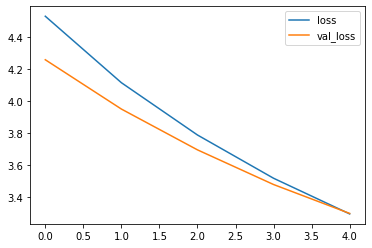

In [17]:
import pandas as pd

losses = pd.DataFrame(history.history)

losses[['loss', 'val_loss']].plot()

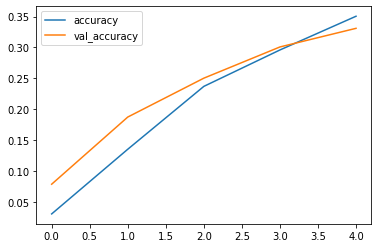

In [18]:
losses[['accuracy', 'val_accuracy']].plot()

# **fine_tuning model**
Unfreeding some layers from the base model

## **changing the base_model**

---
*we try to train the very last 5 layers. usually the layers close to the output define finer structures and features and we want them to be adjusted by our dataset*


In [19]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

## **Recompile**

---
*As we unfreez some layers, we decrease the **learning rate** by 10*


In [20]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

## **Refit the model**

In [21]:
fine_tune_epochs = 10
history_1 = model.fit(train_data , steps_per_epoch=len(train_data),
                    epochs = fine_tune_epochs , initial_epoch = history.epoch[-1], 
                    validation_data = test_data,
                    validation_steps=int(0.15*len(test_data)),
                    )

Epoch 5/10
237/237 [==============================] - 54s 198ms/step - loss: 2.5705 - accuracy: 0.4026 - val_loss: 2.3898 - val_accuracy: 0.3872
Epoch 6/10
237/237 [==============================] - 46s 190ms/step - loss: 2.1248 - accuracy: 0.4677 - val_loss: 2.1829 - val_accuracy: 0.4436
Epoch 7/10
237/237 [==============================] - 43s 179ms/step - loss: 1.9507 - accuracy: 0.5069 - val_loss: 2.1024 - val_accuracy: 0.4563
Epoch 8/10
237/237 [==============================] - 41s 173ms/step - loss: 1.8162 - accuracy: 0.5333 - val_loss: 2.0799 - val_accuracy: 0.4590
Epoch 9/10
237/237 [==============================] - 40s 168ms/step - loss: 1.7017 - accuracy: 0.5653 - val_loss: 1.9995 - val_accuracy: 0.4801
Epoch 10/10
237/237 [==============================] - 38s 160ms/step - loss: 1.6296 - accuracy: 0.5848 - val_loss: 2.0577 - val_accuracy: 0.4624


## **Evaluation**

In [22]:
result2 = model.evaluate(test_data)

790/790 [==============================] - 60s 76ms/step - loss: 1.7534 - accuracy: 0.5354


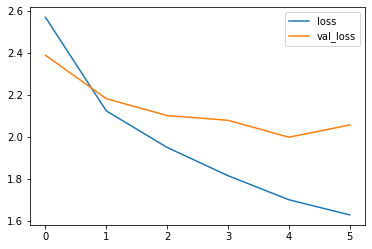

In [23]:
import pandas as pd

losses_1 = pd.DataFrame(history_1.history)

losses_1[['loss', 'val_loss']].plot()

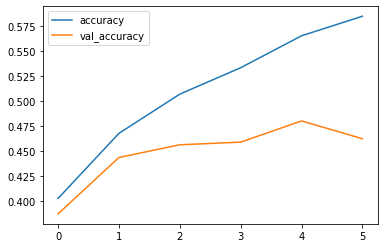

In [24]:
losses_1[['accuracy', 'val_accuracy']].plot()

## **Save and loading the model**

In [25]:
# model.save("drive/MyDrive/Colab Notebooks/101_food_data")

In [26]:
# loaded_model = tf.keras.models.loaded_model("drive/MyDrive/Colab Notebooks/101_food_data")

# **Download pre-trained model** 

## **Download the model**

In [27]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"

--2022-08-09 21:10:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  37.8MB/s    in 1.2s    

2022-08-09 21:10:20 (37.8 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [28]:
import zipfile
zip = zipfile.ZipFile(saved_model_path)
zip.extractall()
zip.close()

In [29]:
import tensorflow as tf

model = tf.keras.models.load_model(saved_model_path.split(".")[0])

In [30]:
loaded_loss, loaded_accuracy = model.evaluate(test_data)

790/790 [==============================] - 63s 78ms/step - loss: 1.8027 - accuracy: 0.6078


## **Prediction**

**probs gives us the probability of belonging each sample to every class**

In [31]:
probs = model.predict(test_data, verbose=1) # we have 790 batches with 32 samples in each len(test_data) = 790

790/790 [==============================] - 65s 80ms/step


In [32]:
probs.shape

(25250, 101)

In [33]:
len(probs)

25250

In [34]:
probs[0].argmax()

52

In [35]:
probs[0].max()

0.8474186

In [36]:
test_data.class_names[probs[0].argmax()]


'gyoza'

**pred_classes_arg gives the arg of each class predicted by the model with the largest probability**

In [37]:
pred_classes_arg = probs.argmax(axis=1)
pred_classes_arg[:10]


array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [38]:
test_data
# data is a tensor with images and then the labels (0,0,0,0,0,0...,1,0,0,0...)

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [39]:
import numpy as np

In [40]:
y_labels = []
for images , labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

**comparing the true labels with the predicted models**

In [41]:
from sklearn.metrics import accuracy_score

In [42]:
Accuracy = accuracy_score(y_labels , pred_classes_arg)
Accuracy

0.6077623762376237

In [43]:
np.isclose(Accuracy,loaded_accuracy)

True

## **Confusion matrix**

In [44]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-09 21:13:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-09 21:13:49 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [45]:
classes = test_data.class_names
len(classes)

101

In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
cf_matrix = confusion_matrix(y_labels, pred_classes_arg)

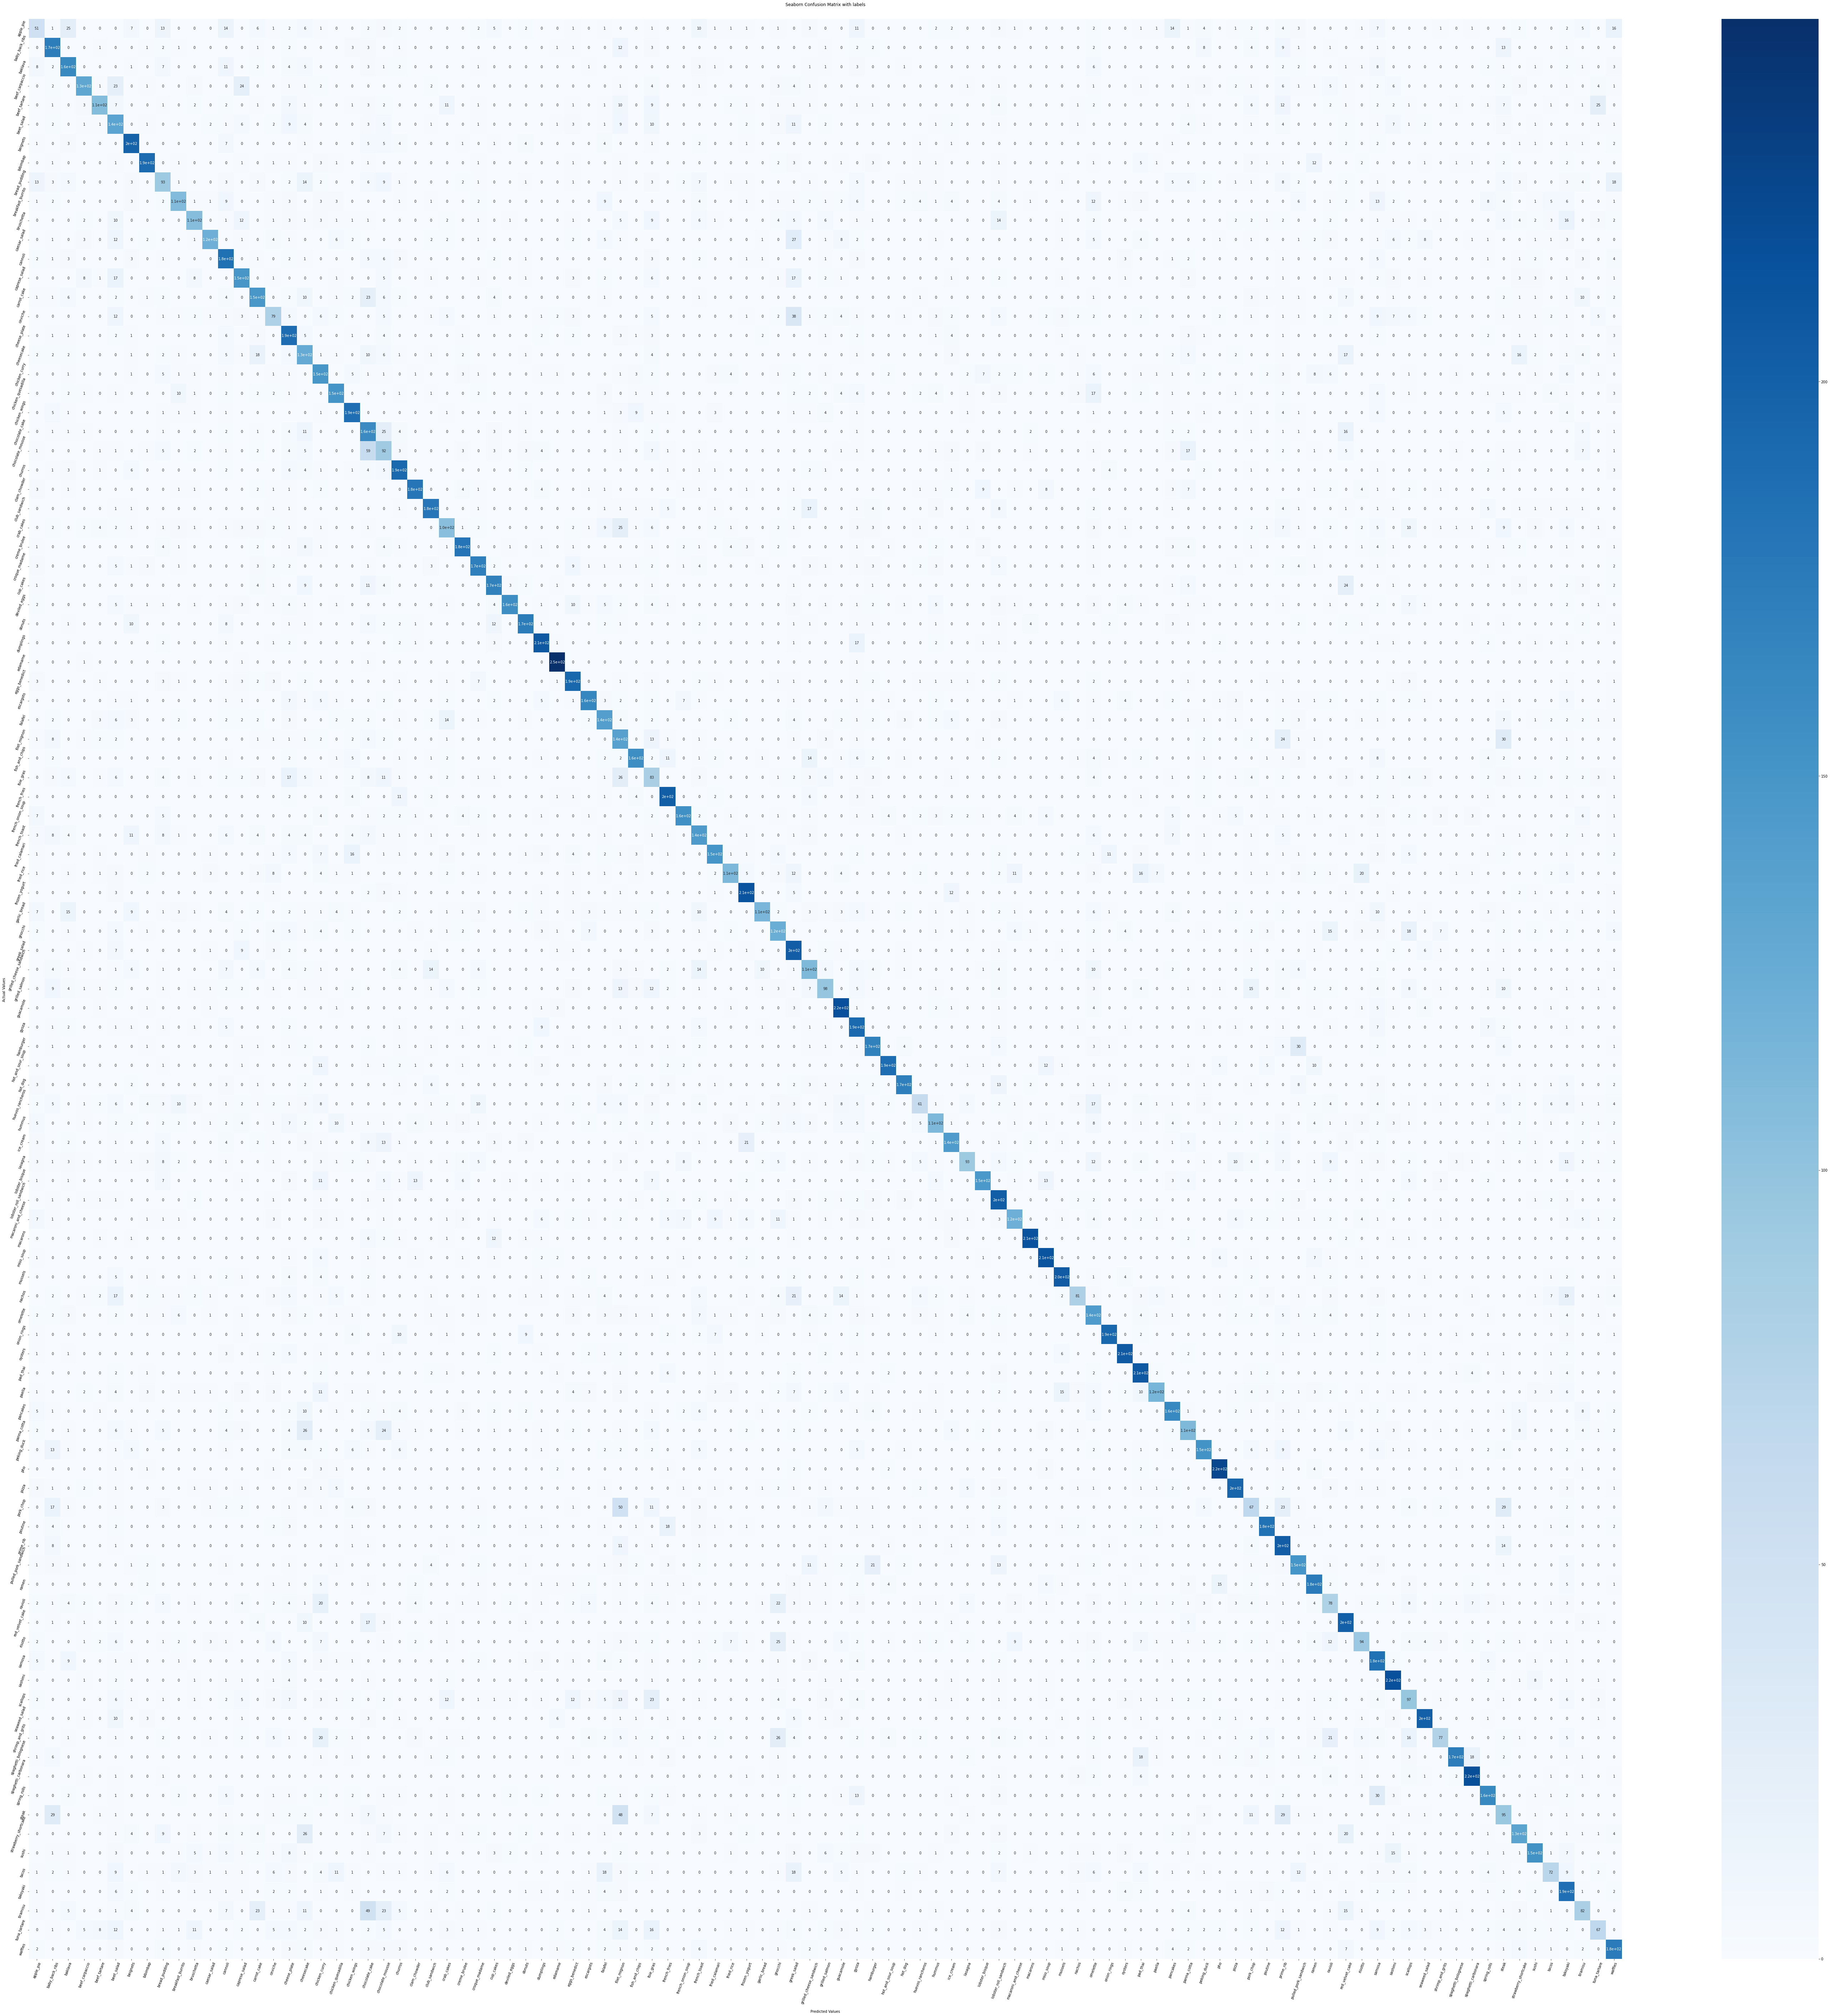

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(100,100))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
# To show the percentage for each cell:
# ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues') 

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

plt.xticks(rotation=70)
plt.yticks(rotation=70)
plt.show()

## **Classification report**

In [49]:
from sklearn.metrics import classification_report

In [50]:
classification_result = classification_report(y_labels , pred_classes_arg, output_dict= True)
classification_result

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [51]:
class_f1_scores = {}
class_recall = {}
class_precision = {}
for key , vals in classification_result.items():
   if key == "accuracy": # stop once we get to accuracy key
    break
   else:
    class_f1_scores[classes[int(key)]] = vals["f1-score"]
    class_recall[classes[int(key)]] = vals["recall"]
    class_precision[classes[int(key)]] = vals["precision"]


In [52]:
first_five = list(class_recall.items())[:5]
first_five

[('apple_pie', 0.204),
 ('baby_back_ribs', 0.692),
 ('baklava', 0.648),
 ('beef_carpaccio', 0.528),
 ('beef_tartare', 0.432)]

In [53]:
import pandas as pd
prediction_results = pd.DataFrame({"class_names" : list(class_f1_scores.keys()), 
                                   "F1_score": list(class_f1_scores.values()),
                                   "recalls": list(class_recall.values()),
                                   "precision": list(class_precision.values())}).sort_values("F1_score", ascending=False)
prediction_results

,class_names,F1_score,recalls,precision
33,edamame,0.937143,0.984,0.894545
63,macarons,0.895397,0.856,0.938596
75,pho,0.866538,0.896,0.838951
91,spaghetti_carbonara,0.847656,0.868,0.828244
69,oysters,0.834008,0.824,0.844262
...,...,...,...,...
56,huevos_rancheros,0.339833,0.244,0.559633
22,chocolate_mousse,0.329159,0.368,0.297735
77,pork_chop,0.308756,0.268,0.364130
39,foie_gras,0.297491,0.332,0.269481


**Bar Chart**

---



---



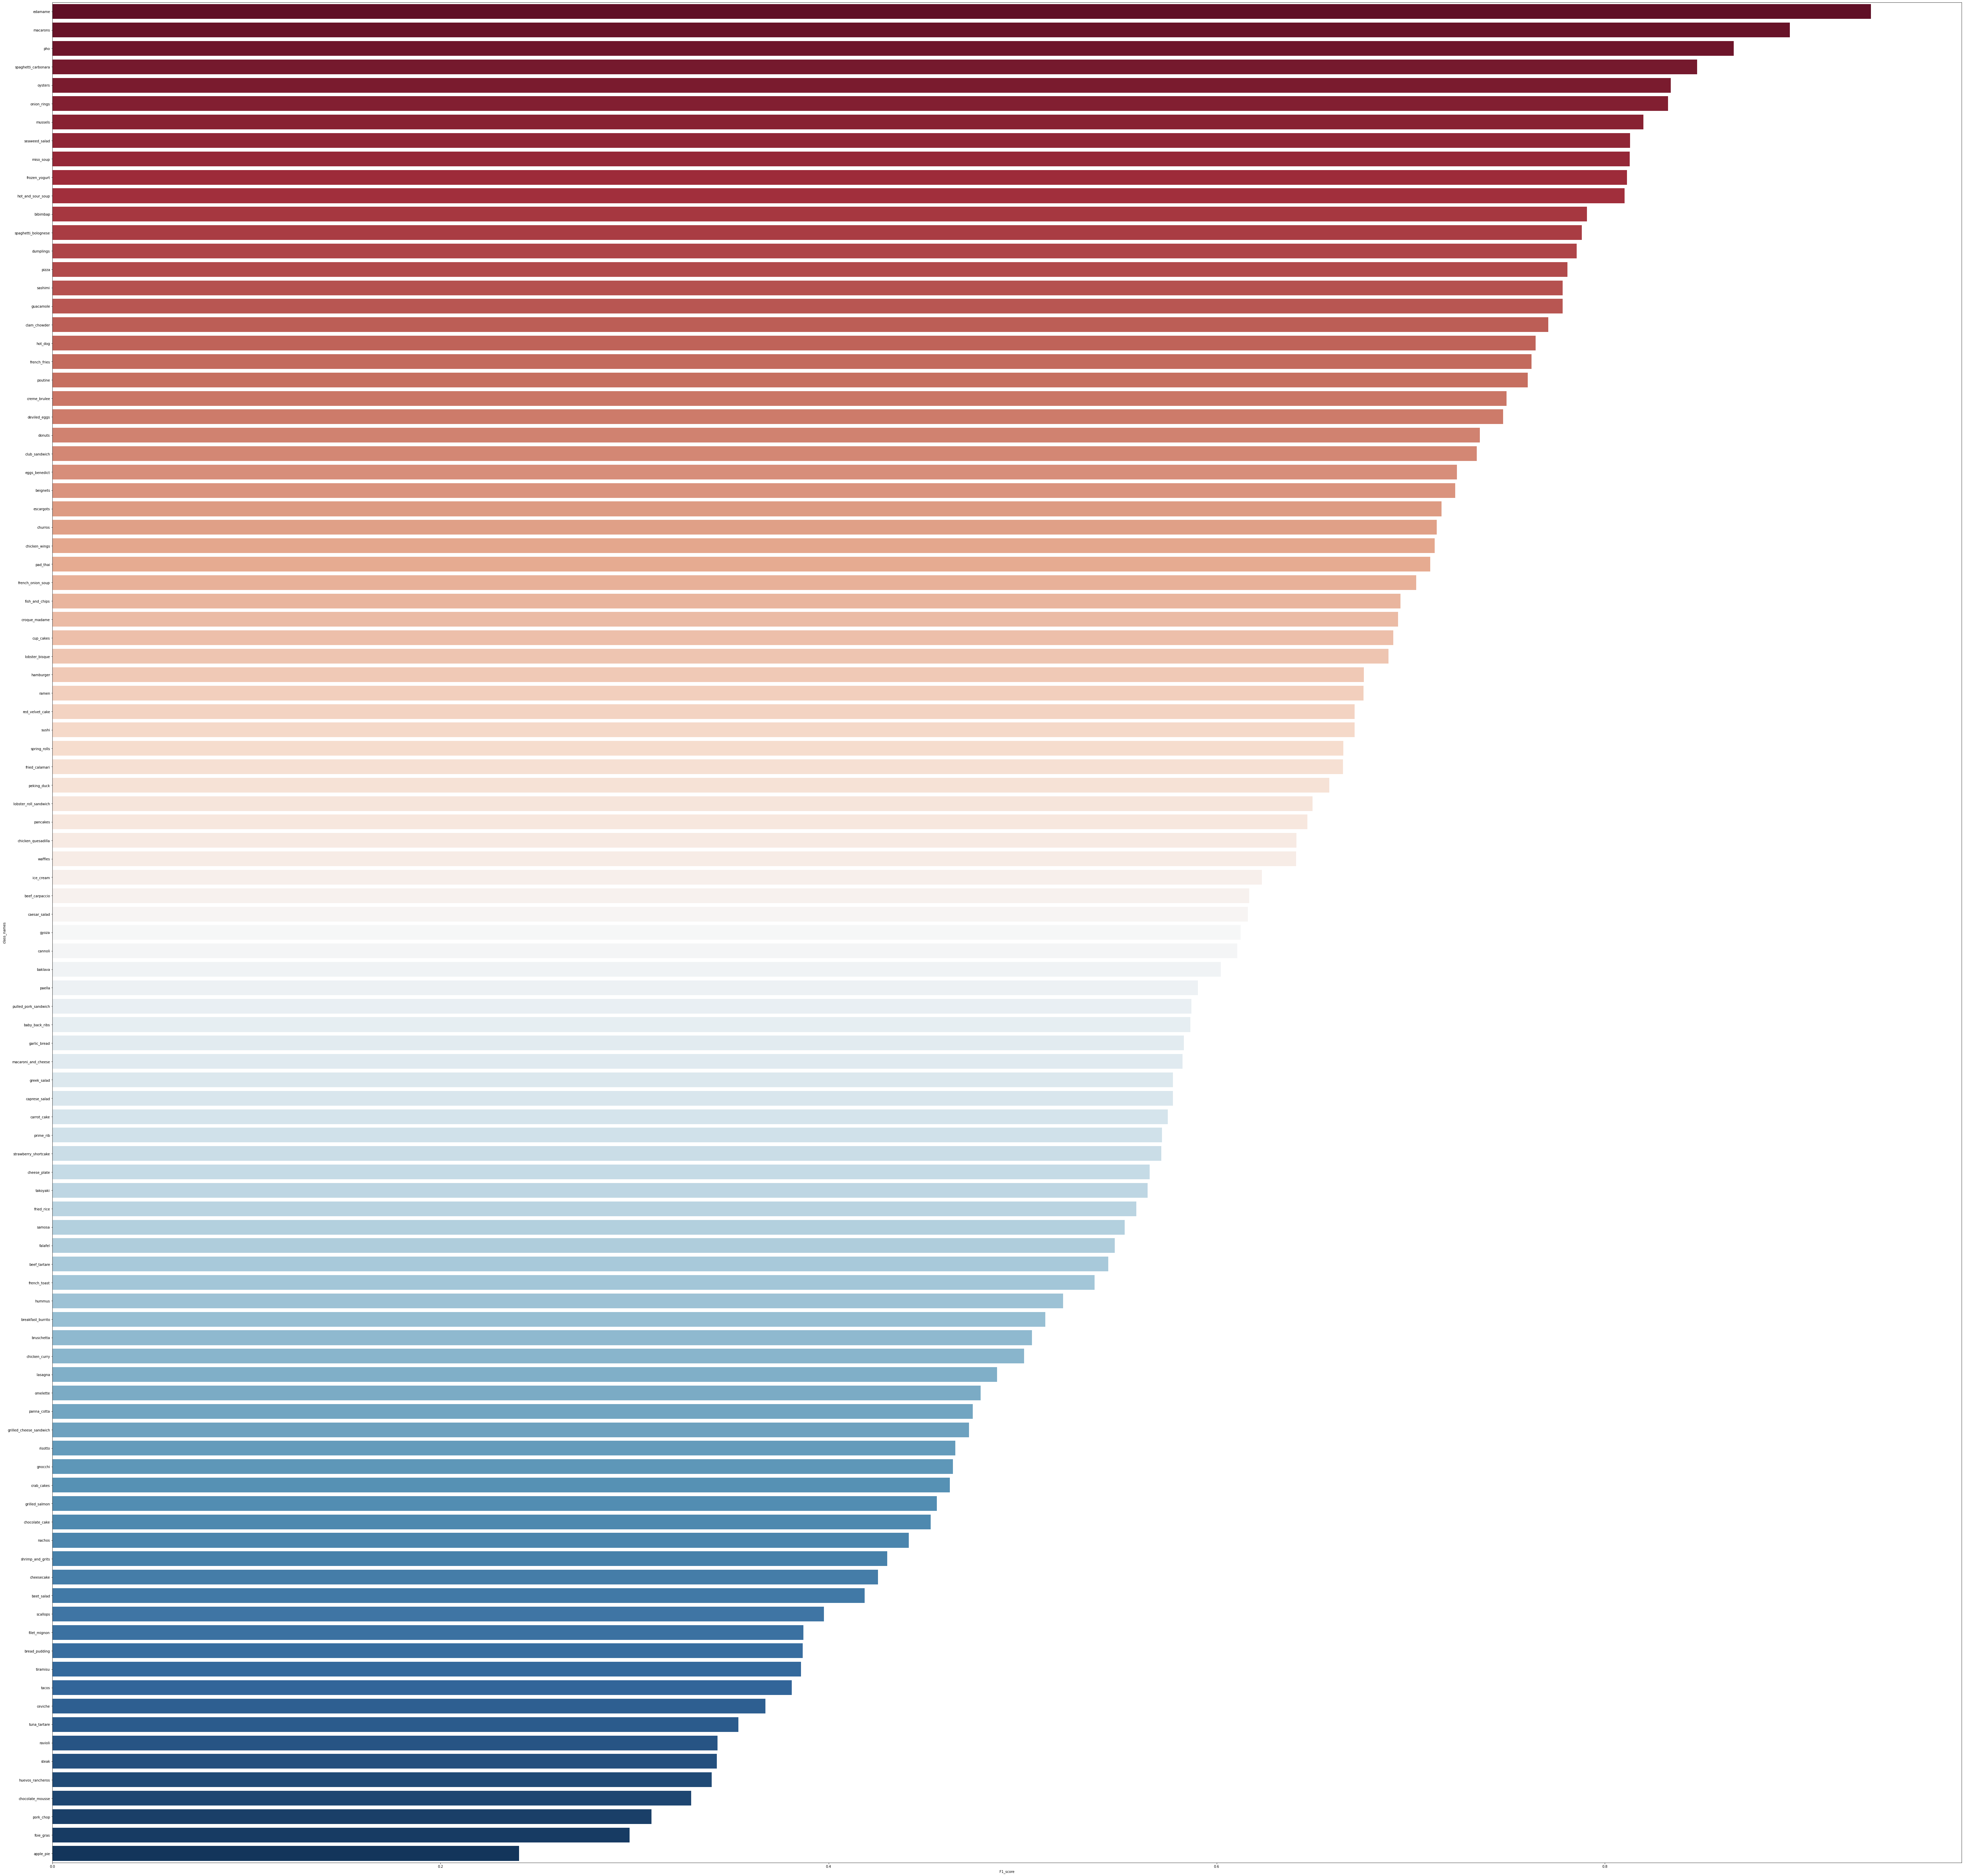

In [54]:
import seaborn as sns
plt.figure(figsize=(100,100))
ax = sns.barplot(x = "F1_score" , y = "class_names" , data= prediction_results , palette="RdBu", errwidth=0)
## to have labels on each bar:
# for i in ax.containers:
#   ax.bar_label(i,)

In [55]:
import matplotlib
print(matplotlib.__version__)


3.2.2


In [56]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

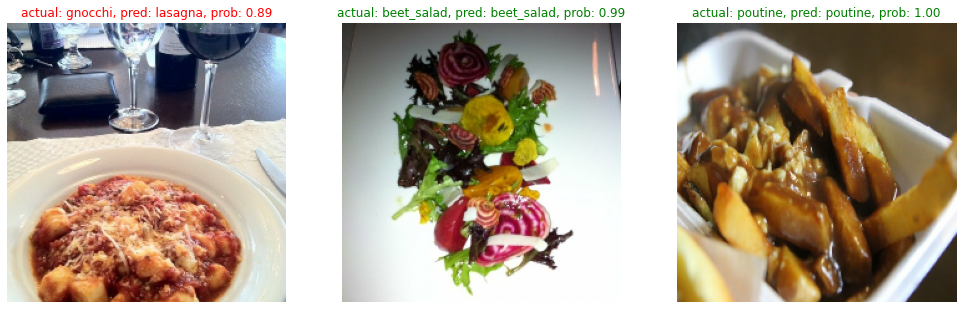

In [57]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(classes)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = classes[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## **finding the most wrong predictions**

### **1. Get all of the image file paths in the test dataset using the list_files() method.**

In [58]:
file_path = []

for images in test_data.list_files("101_food_classes_10_percent/test/*/*jpg", shuffle= False):
  file_path.append(images.numpy())

file_path[:5]


[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg']

### **2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.**

In [59]:
import pandas as pd

new_data = pd.DataFrame({"file_path": file_path , 
                         "G_T_Labels": y_labels ,
                         "Prediction_label": pred_classes_arg , 
                         "Max_pred_prob": probs.max(axis=1) , 
                         "y_true_classname": [classes[i] for i in y_labels],
                        "y_pred_classname": [classes[i] for i in pred_classes_arg]})

In [60]:
new_data

,file_path,G_T_Labels,Prediction_label,Max_pred_prob,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.847419,apple_pie,gyoza
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.964017,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.959259,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,80,0.658607,apple_pie,pulled_pork_sandwich
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,79,0.367900,apple_pie,prime_rib
...,...,...,...,...,...,...
25245,b'101_food_classes_10_percent/test/waffles/942...,100,100,0.972823,waffles,waffles
25246,b'101_food_classes_10_percent/test/waffles/954...,100,16,0.878027,waffles,cheese_plate
25247,b'101_food_classes_10_percent/test/waffles/961...,100,100,0.537900,waffles,waffles
25248,b'101_food_classes_10_percent/test/waffles/970...,100,94,0.501950,waffles,strawberry_shortcake


### **3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).**

In [61]:
new_data['corrct_preds'] = new_data['G_T_Labels'] == new_data['Prediction_label']

In [62]:
new_data.head()

,file_path,G_T_Labels,Prediction_label,Max_pred_prob,y_true_classname,y_pred_classname,corrct_preds
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.847419,apple_pie,gyoza,False
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.964017,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.959259,apple_pie,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,80,0.658607,apple_pie,pulled_pork_sandwich,False
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,79,0.367900,apple_pie,prime_rib,False


### **4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.**

In [63]:
C = new_data[new_data['corrct_preds'] == False].count()
C.values[0]

9904

In [64]:
sorted_data = new_data[new_data['corrct_preds'] == False].sort_values('Max_pred_prob', ascending = False)[:C.values[0]]

In [65]:
sorted_data.head()

,file_path,G_T_Labels,Prediction_label,Max_pred_prob,y_true_classname,y_pred_classname,corrct_preds
21810,b'101_food_classes_10_percent/test/scallops/17...,87,29,0.999997,scallops,cup_cakes,False
231,b'101_food_classes_10_percent/test/apple_pie/8...,0,100,0.999995,apple_pie,waffles,False
15359,b'101_food_classes_10_percent/test/lobster_rol...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'101_food_classes_10_percent/test/strawberry_...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'101_food_classes_10_percent/test/samosa/3140...,85,92,0.999981,samosa,spring_rolls,False


### **5. Visualize the images with the highest prediction probabilities but have the wrong prediction.**

In [66]:
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(sorted_data[start_index:start_index+images_to_view].itertuples()): 
  print(row)

Pandas(Index=18001, file_path=b'101_food_classes_10_percent/test/pancakes/1008491.jpg', G_T_Labels=72, Prediction_label=67, Max_pred_prob=0.9999035596847534, y_true_classname='pancakes', y_pred_classname='omelette', corrct_preds=False)
Pandas(Index=11642, file_path=b'101_food_classes_10_percent/test/garlic_bread/2957596.jpg', G_T_Labels=46, Prediction_label=10, Max_pred_prob=0.9998774528503418, y_true_classname='garlic_bread', y_pred_classname='bruschetta', corrct_preds=False)
Pandas(Index=10847, file_path=b'101_food_classes_10_percent/test/fried_calamari/2294819.jpg', G_T_Labels=43, Prediction_label=68, Max_pred_prob=0.9998719692230225, y_true_classname='fried_calamari', y_pred_classname='onion_rings', corrct_preds=False)
Pandas(Index=23631, file_path=b'101_food_classes_10_percent/test/strawberry_shortcake/2926631.jpg', G_T_Labels=94, Prediction_label=83, Max_pred_prob=0.9998582601547241, y_true_classname='strawberry_shortcake', y_pred_classname='red_velvet_cake', corrct_preds=False)


<Figure size 1080x720 with 0 Axes>

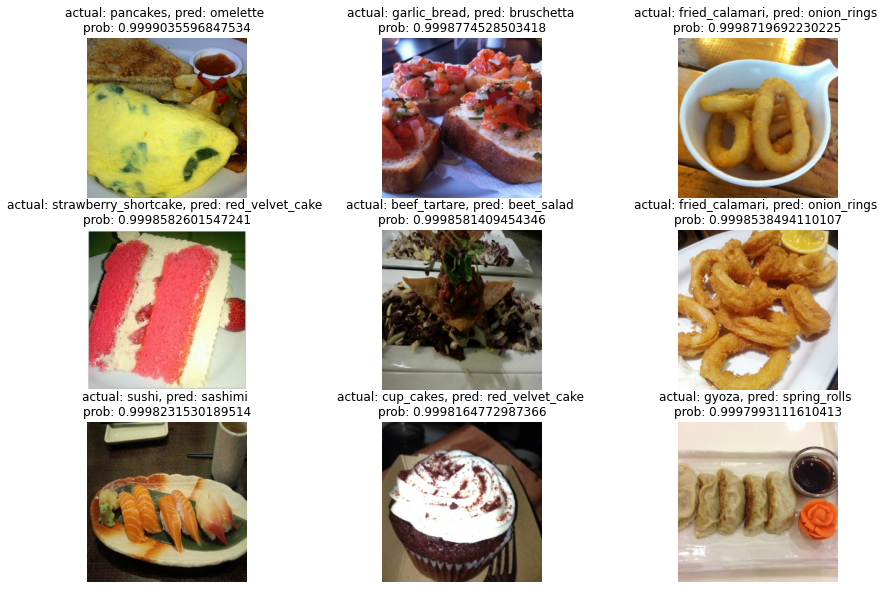

In [67]:
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(sorted_data[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, Max_pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {Max_pred_prob}")
  plt.axis(False)